# Extract RPCA imputed feature table

Here we impute missing values using the OptSpace matrix completion algorithm implemented in the robust Aitchison open-source software DEICODE ([Martino et al., 2019](https://pubmed.ncbi.nlm.nih.gov/30801021/)) within Qiime2 ([Bolyen et al., 2019](https://www.nature.com/articles/s41587-019-0209-9)). This notebook is run in combination with 4_RAPCA_Qiime2.ipynb.

#### Load feature tables and metadata and save in Qiime2 compatible format

load libraries

In [1]:
import pandas as pd
import os

load feature table

In [2]:
bt = pd.read_csv('output/FeatureTable_SamplesOnly.txt', sep = '\t')

In [3]:
bt = bt.T

In [4]:
bt.insert(0, '#OTU ID', bt.index) 

In [5]:
bt = bt.fillna(0)

In [6]:
bt.shape

(1285, 201)

load metadata

In [7]:
md = pd.read_csv('../../data/metadata/Metadata_timsTOF.txt', sep = '\t')

In [8]:
md = md.rename(columns={'filename': '#SampleID'})

In [9]:
set(bt.columns) - set(md['#SampleID'])

{'#OTU ID'}

save feature table and metadata in Qiime2 format

In [10]:
bt.to_csv("output/FeatureTable_SamplesOnly_Qiime.tsv",sep='\t',index=False)

In [11]:
md.to_csv("output/MetaData_timsTOF_Qiime.tsv",sep='\t',index=False)

create the .biom table within 4_RAPCA_Qiime2.ipynb

#### Assess rank of data matrix

In [12]:
## find rank of a matrix
# A = mxn matrix
# m > n
# m: features
# n: samples
# rank(A) < n

In [13]:
import numpy as np
from numpy.linalg import matrix_rank
from biom import load_table

In [14]:
table = load_table('output/FeatureTable_SamplesOnly_Qiime.biom')

In [15]:
table = table.to_dataframe().T
mat = table.to_numpy()

In [16]:
mat.shape

(200, 1285)

In [17]:
matrix_rank(mat) # Full rank matrix

200

# Create distance matrix object and export to .qza format for plotting in Qiime2

In [18]:
import sys
sys.path.append('/Users/madeleineernst/Documents/TemporalStudy/sourcefunctions') 

In [19]:
import biom
import deicode
from deicode.rpca import auto_rpca, rpca
from deicode._rpca_defaults import (DEFAULT_MSC, DEFAULT_MFC,
                                    DEFAULT_ITERATIONS, DEFAULT_MFF) #DEFAULT_RANK
from biom import load_table
import skbio
from typing import Union
from scipy.linalg import svd
import pandas as pd
import numpy as np
from deicode.matrix_completion import MatrixCompletion
from deicode.preprocessing import rclr,closure
from matplotlib import pyplot as plt
#from assets.plotting_helper import biplot
from assets import biplot
from sklearn.preprocessing import scale
%matplotlib inline

In [20]:
def batch_norm(robust_clr_unimputed, table, md, batch_col = 'plate'):
    
    #robust_clr_unimputed = pd.DataFrame(robust_clr_unimputed, index=table.to_dataframe().T.index, columns=table.to_dataframe().T.columns)
    
    robust_clr_unimputed = pd.DataFrame(robust_clr_unimputed, index=table.index, columns=table.columns)
    
    #table = table.to_dataframe().T
    md = md.reindex(robust_clr_unimputed.index)
    
    if (md.index.equals(robust_clr_unimputed.index) == False):
        raise ValueError('metadata index does not equal table index')
    
    #print(md.index.equals(table.index))
    
    robust_clr_unimputed[batch_col] = md[batch_col]
    
    # create dictionary with separate dataframes for each plate
    dict_of_plates = dict(iter(robust_clr_unimputed.groupby(batch_col)))
    # remove batch column to return feature table to original input table
    robust_clr_unimputed = robust_clr_unimputed.drop([batch_col], axis=1)
    # remove batch column for all per batch feature tables
    dict_of_plates = dict((k, v.drop([batch_col], axis=1)) for k,v in dict_of_plates.items())
    # apply scaling over all batch feature tables separately, scale(v, with_mean = True, with_std = True), corresponds to R's scale(v, center = T, scale = T)
    dict_norm_plates = dict((k, scale(v, with_mean = True, with_std = True)) for k,v in dict_of_plates.items())
    
    # return numpy arrays to dataframes for merging
    dict_norm_plates = dict((k, pd.DataFrame(v, index=dict_of_plates[k].index, columns=dict_of_plates[k].columns)) for k,v in dict_norm_plates.items())

    # concatenate all normalized per batch feature tables to one dataframe
    norm_df = pd.concat(dict_norm_plates.values())
    
    # reindex rows as in original feature table
    norm_df = norm_df.reindex(robust_clr_unimputed.index)
    # check if row and column indexes correspond to original input data
    
    if (norm_df.index.equals(robust_clr_unimputed.index) == False):
        raise ValueError('rclr batch imputed table index does not correspond to original table index')
    if (norm_df.columns.equals(robust_clr_unimputed.columns) == False):
        raise ValueError('rclr batch imputed table columns do not correspond to original table columns')
    
    #print(rclr_df.index.equals(table.index))
    #print(rclr_df.columns.equals(table.columns))
    
    # scale and center entire feature table again to account for different ranges in different batches
    norm_df_sc = scale(norm_df, with_mean = True, with_std = True)
    norm_df_sc = pd.DataFrame(norm_df_sc, index=norm_df.index, columns=norm_df.columns)
    
    # return rclr per batch normalized numpy array
    #norm_batch_mat = np.atleast_2d(np.array(norm_df))
    norm_batch_mat = np.atleast_2d(np.array(norm_df_sc))
    return norm_batch_mat

In [21]:
md = pd.read_csv('output/MetaData_timsTOF_Qiime.tsv',sep = '\t', index_col = 0) 

In [22]:
table = load_table('output/FeatureTable_SamplesOnly_Qiime.biom')

In [23]:
n_features, n_samples = table.shape

In [24]:
min_feature_frequency = 5 # 5, 10, 20, 50

In [25]:
n_samples

200

In [26]:
# filter features by N samples presence
def frequency_filter(val, id_, md):
    return (np.sum(val > 0) / n_samples) > (min_feature_frequency / 100)

# filter and import table for each filter above
table = table.filter(frequency_filter, axis='observation')

In [27]:
table.shape

(731, 200)

In [28]:
def rpca_batch(table: biom.Table,
         n_components: Union[int, str] = 10,
         min_sample_count: int = DEFAULT_MSC,
         min_feature_count: int = DEFAULT_MFC,
         min_feature_frequency: float = DEFAULT_MFF,
         max_iterations: int = DEFAULT_ITERATIONS,
         batch_col: str = 'plate',
         metadata: int = md) -> (
        skbio.OrdinationResults,
        skbio.DistanceMatrix):
    """Runs RPCA with an rclr preprocessing step.

       This code will be run by both the standalone and QIIME 2 versions of
       DEICODE.
    """
    # get shape of table
    n_features, n_samples = table.shape

    # filter sample to min seq. depth
    def sample_filter(val, id_, md):
        return sum(val) > min_sample_count

    # filter features to min total counts
    def observation_filter(val, id_, md):
        return sum(val) > min_feature_count

    # filter features by N samples presence
    def frequency_filter(val, id_, md):
        return (np.sum(val > 0) / n_samples) > (min_feature_frequency / 100)

    # filter and import table for each filter above
    table = table.filter(observation_filter, axis='observation')
    table = table.filter(frequency_filter, axis='observation')
    table = table.filter(sample_filter, axis='sample')
    table = table.to_dataframe().T
    # check the table after filtering
    if len(table.index) != len(set(table.index)):
        raise ValueError('Data-table contains duplicate indices')
    if len(table.columns) != len(set(table.columns)):
        raise ValueError('Data-table contains duplicate columns')
    # Robust-clt (rclr) preprocessing and OptSpace (RPCA)
    #opt = MatrixCompletion(n_components=n_components,
                           #max_iterations=max_iterations).fit(rclr_batch(table))
    #opt = MatrixCompletion(n_components=n_components,
                          #max_iterations=max_iterations).fit(rclr_batch(table, md, batch_col = batch_col))
    opt = MatrixCompletion(n_components=10,
                          max_iterations=max_iterations).fit(batch_norm(rclr(table), table, md, batch_col = batch_col)) 
    # get new n-comp when applicable
    n_components = opt.s.shape[0]
    # get PC column labels for the skbio OrdinationResults
    rename_cols = ['PC' + str(i + 1) for i in range(n_components)]
    # get completed matrix for centering
    X = opt.sample_weights @ opt.s @ opt.feature_weights.T
    # center again around zero after completion
    X = X - X.mean(axis=0)
    X = X - X.mean(axis=1).reshape(-1, 1)
    # re-factor the data
    u, s, v = svd(X)
    # only take n-components
    u = u[:, :n_components]
    v = v.T[:, :n_components]
    # calc. the new variance using projection
    p = s**2 / np.sum(s**2)
    p = p[:n_components]
    s = s[:n_components]
    # save the loadings
    feature_loading = pd.DataFrame(v, index=table.columns,
                                   columns=rename_cols)
    sample_loading = pd.DataFrame(u, index=table.index,
                                  columns=rename_cols)
    # % var explained
    proportion_explained = pd.Series(p, index=rename_cols)
    # get eigenvalues
    eigvals = pd.Series(s, index=rename_cols)

    # if the n_components is two add PC3 of zeros
    # this is referenced as in issue in
    # <https://github.com/biocore/emperor/commit
    # /a93f029548c421cb0ba365b4294f7a5a6b0209ce>
    # discussed in DEICODE -- PR#29
    if n_components == 2:
        feature_loading['PC3'] = [0] * len(feature_loading.index)
        sample_loading['PC3'] = [0] * len(sample_loading.index)
        eigvals.loc['PC3'] = 0
        proportion_explained.loc['PC3'] = 0

    # save ordination results
    short_method_name = 'rpca_biplot'
    long_method_name = '(Robust Aitchison) RPCA Biplot'
    ord_res = skbio.OrdinationResults(
        short_method_name,
        long_method_name,
        eigvals.copy(),
        samples=sample_loading.copy(),
        features=feature_loading.copy(),
        proportion_explained=proportion_explained.copy())
    # save distance matrix
    dist_res = skbio.stats.distance.DistanceMatrix(
        opt.distance, ids=sample_loading.index)
    
    # reconstruct imputed data
    robust_clr_imputed = opt.sample_weights @ opt.s @ opt.feature_weights.T
    
    return ord_res, dist_res, robust_clr_imputed

In [29]:
def auto_rpca_batch(table: biom.Table,
              n_components: Union[int, str] = 10,
              min_sample_count: int = DEFAULT_MSC,
              min_feature_count: int = DEFAULT_MFC,
              min_feature_frequency: float = DEFAULT_MFF,
              max_iterations: int = DEFAULT_ITERATIONS,
              batch_col: str = 'Plate',
              metadata: int = md) -> (
        skbio.OrdinationResults,
        skbio.DistanceMatrix):
    """Runs RPCA but with auto estimation of the
       rank peramater.
    """
    #md = metadata.to_dataframe()
    ord_res, dist_res, robust_clr_imputed = rpca_batch(table,
                             n_components='auto',
                             min_sample_count=min_sample_count,
                             min_feature_count=min_feature_count,
                             min_feature_frequency=min_feature_frequency,
                             max_iterations=max_iterations,
                             metadata = md,
                             batch_col = batch_col)
    return ord_res, dist_res, robust_clr_imputed

In [30]:
# perform RPCA with auto. rank estimation
ordination, distance, robust_clr_imputed = auto_rpca_batch(table, n_components = 100, metadata = md, batch_col = 'plate')

/Users/madeleineernst/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/data.py:157: RuntimeWarning: Mean of empty slice
  mean_ = np.nanmean(X, axis)
/Users/madeleineernst/anaconda3/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1628: RuntimeWarning: Degrees of freedom <= 0 for slice.
  keepdims=keepdims)
/Users/madeleineernst/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/data.py:165: RuntimeWarning: Mean of empty slice
  mean_1 = np.nanmean(Xr, axis=0)
/Users/madeleineernst/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/data.py:172: UserWarning: Numerical issues were encountered when centering the data and might not be solved. Dataset may contain too large values. You may need to prescale your features.
  warnings.warn("Numerical issues were encountered "
/Users/madeleineernst/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/data.py:182: RuntimeWarning: Mean of empty slice
  mean_2 = np.nanmean(Xr, axis=0)
/Users/madeleineernst/a

In [31]:
#robust_clr_unimputed = rclr(table)
robust_clr_unimputed = batch_norm(rclr(table.to_dataframe().T), table.to_dataframe().T, md, batch_col = 'plate')
# do pre-processing step within RPCA
table = table.to_dataframe().T

/Users/madeleineernst/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/data.py:157: RuntimeWarning: Mean of empty slice
  mean_ = np.nanmean(X, axis)
/Users/madeleineernst/anaconda3/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1628: RuntimeWarning: Degrees of freedom <= 0 for slice.
  keepdims=keepdims)
/Users/madeleineernst/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/data.py:165: RuntimeWarning: Mean of empty slice
  mean_1 = np.nanmean(Xr, axis=0)
/Users/madeleineernst/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/data.py:172: UserWarning: Numerical issues were encountered when centering the data and might not be solved. Dataset may contain too large values. You may need to prescale your features.
  warnings.warn("Numerical issues were encountered "
/Users/madeleineernst/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/data.py:182: RuntimeWarning: Mean of empty slice
  mean_2 = np.nanmean(Xr, axis=0)
/Users/madeleineernst/a

Assess correlation between imputed and non-imputed feature tables ([C.Martino](https://github.com/biocore/DEICODE/pull/59#issuecomment-784701433))

In [32]:
# use this to mask any "imputed" values
zero_mask = (table == 0.0)

In [33]:
# re-mask imputed values for comparison
robust_clr_imputed_masked = robust_clr_imputed.copy()
robust_clr_imputed_masked[zero_mask] = np.nan

In [34]:
robust_clr_unimputed.shape

(200, 731)

In [35]:
# flatten and keep only observed
x = robust_clr_unimputed.ravel()
y = robust_clr_imputed_masked.ravel()
x = x[np.isfinite(x)]
y = y[np.isfinite(y)]

In [36]:
# print the correlation between values
print(np.corrcoef(x, y))

[[1.         0.72105497]
 [0.72105497 1.        ]]


In [37]:
len(x)

78235

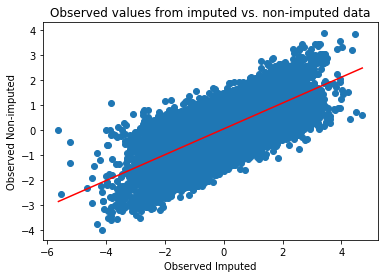

In [38]:
# plot the observed values
plt.scatter(x, y)
plt.title('Observed values from imputed vs. non-imputed data')
plt.xlabel('Observed Imputed')
plt.ylabel('Observed Non-imputed')
plt.plot(np.unique(x),
         np.poly1d(np.polyfit(x, y, 1))(np.unique(x)),
         color='red')
plt.show()

plot only one feature

In [39]:
table.shape

(200, 731)

In [40]:
robust_clr_unimputed.shape

(200, 731)

In [41]:
robust_clr_unimputed_pd = pd.DataFrame(robust_clr_unimputed, index=table.index, columns=table.columns)

In [42]:
robust_clr_imputed_masked_pd = pd.DataFrame(robust_clr_imputed_masked, index=table.index, columns=table.columns)

In [43]:
robust_clr_unimputed_pd.columns

Index(['5', '9', '10', '14', '16', '25', '29', '35', '37', '44',
       ...
       '7260', '7355', '7634', '7659', '7720', '7961', '8170', '8195', '8292',
       '8306'],
      dtype='object', length=731)

In [44]:
x = robust_clr_unimputed_pd['16']
y = robust_clr_imputed_masked_pd['16']

[[1.         0.89883206]
 [0.89883206 1.        ]]


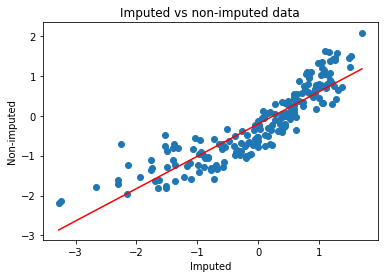

In [45]:
print(np.corrcoef(x, y))

plt.scatter(x, y) 
plt.title('Imputed vs non-imputed data')
plt.xlabel('Imputed')
plt.ylabel('Non-imputed')
plt.plot(np.unique(x), np.poly1d(np.polyfit(x, y, 1))(np.unique(x)), color='red')
plt.show()

In [46]:
robust_clr_imputed.shape

(200, 731)

In [47]:
table.shape

(200, 731)

In [48]:
out = pd.DataFrame(robust_clr_imputed, index=table.index, columns=table.columns)

In [49]:
out = out.T

In [50]:
out.insert(0, '#OTU ID', out.index) 

assess sparsity in imputed and non-imputed feature table

In [51]:
(out != 0).sum(1).sum()/(out.shape[0]*out.shape[1])

1.0

In [52]:
(table != 0).sum(1).sum()/(table.shape[0]*table.shape[1])

0.5351231190150478

In [53]:
out.shape

(731, 201)

save imputed data table 

In [54]:
out.to_csv('output/RAPCA_ImputedData_Rank10_NA_5.tsv', sep = '\t',index=False)

#### save distance matrix

In [55]:
# the sample loadings
spca_df = ordination.samples

In [56]:
# the feature loadings
fpca_df = ordination.features

In [57]:
# merge the sample metadata and loadings
spca_df = pd.concat([spca_df, md.reindex(spca_df.index)],
                    axis=1, sort=True)

save distance matrix to file

In [58]:
distance.write('output/RAPCA_ImputedData_Rank10_NA_5_distance.txt')

'output/RAPCA_ImputedData_Rank10_NA_5_distance.txt'

continue with 4_RAPCA_Qiime2.ipynb to create PCoA plots within Qiime2.

In [59]:
import session_info

session_info.show()